<a href="https://colab.research.google.com/github/klstak/NutriGie/blob/machine-learning/Machine%20Learning/Collab/modeling_tf_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

In [4]:
print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.12.0


In [20]:
# Specify the file path
file_path = '/content/drive/MyDrive/capstone/ML/users_final.csv'

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)
data

,user_id,usia,jenis_kelamin,tinggi_badan,berat_badan,aktivitas_fisik,pekerjaan_mahasiswa,pekerjaan_pns,pekerjaan_polisi,pekerjaan_siswa,...,kental,digoreng,direbus,dibakar,dikukus,cepat_saji,beli,ranking,makanan,rating
0,1,21,0,0.315789,0.365385,0,1,0,0,0,...,0.333333,0.888889,0.666667,0.111111,0.222222,1,1,1,63,5.0
1,1,21,0,0.315789,0.365385,0,1,0,0,0,...,0.333333,0.888889,0.666667,0.111111,0.222222,1,1,2,4,4.8
2,1,21,0,0.315789,0.365385,0,1,0,0,0,...,0.333333,0.888889,0.666667,0.111111,0.222222,1,1,3,129,4.5
3,1,21,0,0.315789,0.365385,0,1,0,0,0,...,0.333333,0.888889,0.666667,0.111111,0.222222,1,1,4,145,4.2
4,1,21,0,0.315789,0.365385,0,1,0,0,0,...,0.333333,0.888889,0.666667,0.111111,0.222222,1,1,5,135,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,60,20,1,0.921053,0.423077,1,0,0,1,0,...,0.444444,0.777778,0.555556,0.777778,0.777778,1,1,1,5,5.0
1196,60,20,1,0.921053,0.423077,1,0,0,1,0,...,0.444444,0.777778,0.555556,0.777778,0.777778,1,1,2,6,4.8
1197,60,20,1,0.921053,0.423077,1,0,0,1,0,...,0.444444,0.777778,0.555556,0.777778,0.777778,1,1,3,172,4.5
1198,60,20,1,0.921053,0.423077,1,0,0,1,0,...,0.444444,0.777778,0.555556,0.777778,0.777778,1,1,4,169,4.2


# 2. Feature Engineering

# *2.1 Separate data based on Meal Time*

In [21]:
# Split the data based on meal time
breakfast_data = data[data['waktu_makan'] == 'sarapan']
lunch_data = data[data['waktu_makan'] == 'makansiang']
dinner_data = data[data['waktu_makan'] == 'makanmalam']
snack_data = data[data['waktu_makan'] == 'snack']

In [22]:
print("breakfast data:", breakfast_data.shape)
print("lunch data:", lunch_data.shape)
print("dinner data:", dinner_data.shape)
print("snack data:", snack_data.shape)

breakfast data: (300, 33)
lunch data: (300, 33)
dinner data: (300, 33)
snack data: (300, 33)


# 2.2 Creating User-Item Matrix

In [23]:
# Create a mapping for user IDs
user_ids = np.unique(data['user_id'])
user_id_map = {user_id: idx for idx, user_id in enumerate(user_ids)}

# Create a mapping for items for each meal time
meal_times = ['breakfast', 'lunch', 'dinner', 'snack']
item_maps = {}

for meal_time, data in zip(meal_times, [breakfast_data, lunch_data, dinner_data, snack_data]):
    items = np.arange(0, 175)  # Adjust the range based on the total number of food items
    item_map = {item: idx for idx, item in enumerate(items)}
    item_maps[meal_time] = item_map

# Calculate the dimensions of the user-item matrices
num_users = len(user_ids)
num_items = max(len(item_map) for item_map in item_maps.values())

# Initialize the user-item matrices for each meal time
user_item_matrices = {meal_time: np.zeros((num_users, num_items)) for meal_time in meal_times}

# Fill in the user-item matrices with ratings for each meal time
for meal_time, data in zip(meal_times, [breakfast_data, lunch_data, dinner_data, snack_data]):
    item_map = item_maps[meal_time]

    for _, row in data.iterrows():
        user_id = row['user_id']
        item = row['makanan']
        rating = row['rating']
        user_idx = user_id_map[user_id]
        item_idx = item_map[item]
        user_item_matrices[meal_time][user_idx, item_idx] = rating

In [24]:
user_item_matrices

{'breakfast': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'lunch': array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 5. , 4.8, ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]]),
 'dinner': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'snack': array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ...,

In [25]:
user_item_matrices['lunch'][0,63]

4.0

# 2.3 Matrix Factorization

In [27]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095472 sha256=1984054ed2af26188a54784d301a7a7994eb55b8b4cd6db4c499439a28ba9b48
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [28]:
from surprise import Dataset, Reader, SVD
# Create a Surprise-compatible user-item dataset
user_item_data = []
for meal_time in meal_times:
    user_item_matrix = user_item_matrices[meal_time]
    for user_idx in range(num_users):
        for item_idx in range(num_items):
            rating = user_item_matrix[user_idx, item_idx]
            if rating != 0:
                user_id = list(user_id_map.keys())[list(user_id_map.values()).index(user_idx)]
                item = list(item_map.keys())[list(item_map.values()).index(item_idx)]
                user_item_data.append((user_id, item, rating))

    # Define the Reader object to parse the dataset
    reader = Reader(rating_scale=(1, 5))

    # Load the user-item data into Surprise Dataset
    data = Dataset.load_from_df(pd.DataFrame(user_item_data, columns=['user_id', 'item_id', 'rating']), reader)

    # Create an instance of the SVD algorithm
    svd = SVD()

    # Train the model on the user-item data
    trainset = data.build_full_trainset()
    svd.fit(trainset)

    # Get the estimated ratings for all users and items
    estimated_ratings = np.zeros((num_users, num_items))
    for user_idx in range(num_users):
        for item_idx in range(num_items):
            user_id = list(user_id_map.keys())[list(user_id_map.values()).index(user_idx)]
            item = list(item_map.keys())[list(item_map.values()).index(item_idx)]
            estimated_ratings[user_idx, item_idx] = svd.predict(user_id, item).est
    # Update the user-item matrix for the current meal time with the estimated ratings
    user_item_matrices[meal_time] = np.round(estimated_ratings,decimals=2 )


In [29]:
# Print the completed user-item matrices for each meal time
for meal_time in meal_times:
    print(f"Completed User-Item Matrix for {meal_time}:")
    print(user_item_matrices[meal_time])

Completed User-Item Matrix for breakfast:
[[4.46 4.46 4.54 ... 4.46 4.46 4.46]
 [4.53 4.53 4.48 ... 4.53 4.53 4.53]
 [4.5  4.5  4.53 ... 4.5  4.5  4.5 ]
 ...
 [4.49 4.49 4.52 ... 4.49 4.49 4.49]
 [4.49 4.49 4.32 ... 4.49 4.49 4.49]
 [4.5  4.5  4.52 ... 4.5  4.5  4.5 ]]
Completed User-Item Matrix for lunch:
[[4.48 4.3  4.4  ... 4.48 4.48 4.64]
 [4.51 4.59 4.43 ... 4.56 4.51 4.54]
 [4.47 4.64 4.49 ... 4.57 4.47 4.44]
 ...
 [4.45 4.58 4.51 ... 4.45 4.45 4.41]
 [4.51 4.66 4.63 ... 4.5  4.51 4.5 ]
 [4.49 4.59 4.6  ... 4.58 4.49 4.6 ]]
Completed User-Item Matrix for dinner:
[[4.47 4.58 4.65 ... 4.44 4.45 4.54]
 [4.53 4.66 4.44 ... 4.56 4.48 4.52]
 [4.5  4.38 4.52 ... 4.53 4.62 4.47]
 ...
 [4.52 4.66 4.61 ... 4.5  4.6  4.53]
 [4.51 4.67 4.6  ... 4.32 4.52 4.52]
 [4.49 4.56 4.38 ... 4.38 4.48 4.42]]
Completed User-Item Matrix for snack:
[[4.47 4.66 4.66 ... 4.35 4.51 4.43]
 [4.52 4.69 4.72 ... 4.71 4.38 4.53]
 [4.51 4.65 4.67 ... 4.51 4.54 4.68]
 ...
 [4.47 4.58 4.52 ... 4.61 4.5  4.36]
 [4.46

In [31]:
# Calculate RMSE for each meal time
for meal_time in meal_times:
    user_item_matrix = user_item_matrices[meal_time]

    # Create a list to store the original and estimated ratings
    original_ratings = []
    estimated_ratings = []

    for user_idx in range(num_users):
        for item_idx in range(num_items):
            rating = user_item_matrix[user_idx, item_idx]
            if rating != 0:
                user_id = list(user_id_map.keys())[list(user_id_map.values()).index(user_idx)]
                item = list(item_map.keys())[list(item_map.values()).index(item_idx)]
                original_ratings.append(rating)
                estimated_rating = svd.predict(user_id, item).est
                estimated_ratings.append(estimated_rating)

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(original_ratings, estimated_ratings))
    print(f"RMSE for {meal_time}: {rmse}")

RMSE for breakfast: 0.1346547455696906
RMSE for lunch: 0.13772212215534854
RMSE for dinner: 0.1331679770075019
RMSE for snack: 0.0028825708474233907


# 3. Modeling

# *3.1 Define X*

In [33]:
#Define the X

X = {}

# Create X matrix for each meal time
X['breakfast'] = breakfast_data.drop(columns=["user_id","makanan","rating","ranking",'waktu_makan']).drop_duplicates()
X['lunch'] = lunch_data.drop(columns=["user_id","makanan","rating","ranking",'waktu_makan']).drop_duplicates()
X['dinner'] = dinner_data.drop(columns=["user_id","makanan","rating","ranking",'waktu_makan']).drop_duplicates()
X['snack'] = snack_data.drop(columns=["user_id","makanan","rating","ranking",'waktu_makan']).drop_duplicates()

In [34]:
X['snack'].columns

Index(['usia', 'jenis_kelamin', 'tinggi_badan', 'berat_badan',
       'aktivitas_fisik', 'pekerjaan_mahasiswa', 'pekerjaan_pns',
       'pekerjaan_polisi', 'pekerjaan_siswa', 'pekerjaan_staff',
       'pekerjaan_wirausaha', 'harga_minimal', 'harga_maksimal', 'asin',
       'manis', 'asam', 'gurih', 'pedas', 'renyah', 'halus', 'creamy',
       'kental', 'digoreng', 'direbus', 'dibakar', 'dikukus', 'cepat_saji',
       'beli'],
      dtype='object')

# *3.2 Define y*

In [32]:
#Define the y
y = {}

# Define y as a matrix for each meal time
for meal_time in meal_times:
    user_item_matrix = user_item_matrices[meal_time]
    y[meal_time] = user_item_matrix

In [35]:
y

{'breakfast': array([[4.46, 4.46, 4.54, ..., 4.46, 4.46, 4.46],
        [4.53, 4.53, 4.48, ..., 4.53, 4.53, 4.53],
        [4.5 , 4.5 , 4.53, ..., 4.5 , 4.5 , 4.5 ],
        ...,
        [4.49, 4.49, 4.52, ..., 4.49, 4.49, 4.49],
        [4.49, 4.49, 4.32, ..., 4.49, 4.49, 4.49],
        [4.5 , 4.5 , 4.52, ..., 4.5 , 4.5 , 4.5 ]]),
 'lunch': array([[4.48, 4.3 , 4.4 , ..., 4.48, 4.48, 4.64],
        [4.51, 4.59, 4.43, ..., 4.56, 4.51, 4.54],
        [4.47, 4.64, 4.49, ..., 4.57, 4.47, 4.44],
        ...,
        [4.45, 4.58, 4.51, ..., 4.45, 4.45, 4.41],
        [4.51, 4.66, 4.63, ..., 4.5 , 4.51, 4.5 ],
        [4.49, 4.59, 4.6 , ..., 4.58, 4.49, 4.6 ]]),
 'dinner': array([[4.47, 4.58, 4.65, ..., 4.44, 4.45, 4.54],
        [4.53, 4.66, 4.44, ..., 4.56, 4.48, 4.52],
        [4.5 , 4.38, 4.52, ..., 4.53, 4.62, 4.47],
        ...,
        [4.52, 4.66, 4.61, ..., 4.5 , 4.6 , 4.53],
        [4.51, 4.67, 4.6 , ..., 4.32, 4.52, 4.52],
        [4.49, 4.56, 4.38, ..., 4.38, 4.48, 4.42]]),
 'sna

# *3.3 Split Training and Testing Set*

In [36]:
#Split Training and Testing Set
for meal_time in meal_times:
    X_meal = X[meal_time]
    y_meal = y[meal_time]
    # Split the data into training and testing sets for each meal time
    X_train, X_test, y_train, y_test = train_test_split(X_meal, y_meal, test_size=0.2, random_state=40)

In [40]:
for meal_time in meal_times:
    X_meal = X[meal_time]
    y_meal = y[meal_time]
    X_train, X_test, y_train, y_test = train_test_split(X_meal, y_meal, test_size=0.2, random_state=40) 
    print("Meal Time:", meal_time)
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
    print("-------------------")

Meal Time: breakfast
X_train shape: (48, 28)
y_train shape: (48, 175)
X_test shape: (12, 28)
y_test shape: (12, 175)
-------------------
Meal Time: lunch
X_train shape: (48, 28)
y_train shape: (48, 175)
X_test shape: (12, 28)
y_test shape: (12, 175)
-------------------
Meal Time: dinner
X_train shape: (48, 28)
y_train shape: (48, 175)
X_test shape: (12, 28)
y_test shape: (12, 175)
-------------------
Meal Time: snack
X_train shape: (48, 28)
y_train shape: (48, 175)
X_test shape: (12, 28)
y_test shape: (12, 175)
-------------------


# *3.4 Modeling*

In [41]:
# Hyperparameters
HIDDEN_UNITS = 1000
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 5
TOP_N = 5
INPUT_LENGTH = X_train.shape[1]

In [46]:
#Function to evaluate model
def evaluate_model(model, X_test, y_test):
    predicted_ratings = model.predict(X_test)
    mae = mean_absolute_error(y_test, predicted_ratings)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_ratings))
    return mae, rmse, predicted_ratings 

# Function to calculate precision@k and recall@k
def calculate_precision_recall(y_test, predicted_ratings, k):
    precision_scores = []
    recall_scores = []
    for i in range(y_test.shape[0]):
        actual_items = np.argsort(y_test[i])[-k:][::-1]
        recommended_items = np.argsort(predicted_ratings[i])[-k:][::-1]
        tp = sum([1 for item in recommended_items if item in actual_items])
        precision = tp / k
        recall = tp / len(actual_items) if actual_items.size else 0
        precision_scores.append(precision)
        recall_scores.append(recall)
    return np.mean(precision_scores), np.mean(recall_scores)

# Function to run the recommendation system for a specific meal time
def run_recommendation_system(X_train, y_train, X_test, y_test):

    # Initialize the model
    model = Sequential([
        Dense(HIDDEN_UNITS, activation='relu', input_shape=(INPUT_LENGTH,)),
        Dropout(DROPOUT_RATE),
        Dense(y_train.shape[1], activation='linear')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Print the model summary
    model.summary()
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

    # Save the model
    save_path = f"model_{meal_time}.h5"
    model.save(save_path)

    # Evaluate the model
    mae, rmse, predicted_ratings = evaluate_model(model, X_test, y_test)
    precision, recall = calculate_precision_recall(y_test, predicted_ratings, k=TOP_N)

    # Plot validation and training loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss for ' + meal_time)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    print("MAE :", mae)
    print("RMSE :", rmse)
    print("Precision@k :", precision)
    print("Recall@k :", recall)

    return mae, rmse, precision, recall

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1000)              29000     
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0         
                                                                 
 dense_11 (Dense)            (None, 175)               175175    
                                                                 
Total params: 204,175
Trainable params: 204,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 169ms/step - loss: 20.2774 - val_loss: 13.7451
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 12.9753 - val_loss: 8.0456
Epoch 3/50
2/2 [==============================] - 0s 35ms/step - loss: 7.6087 - val_loss: 4.2663
Epoch 4/50
2/2 [=

1/1 [==============================] - 0s 57ms/step


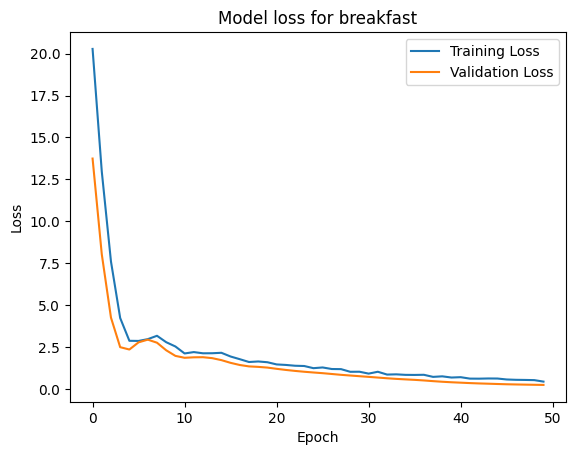

MAE : 0.40747338510240816
RMSE : 0.5069427097727794
Precision@k : 0.26666666666666666
Recall@k : 0.26666666666666666
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1000)              29000     
                                                                 
 dropout_6 (Dropout)         (None, 1000)              0         
                                                                 
 dense_13 (Dense)            (None, 175)               175175    
                                                                 
Total params: 204,175
Trainable params: 204,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 155ms/step - loss: 20.3506 - val_loss: 13.7515
Epoch 2/50
2/2 [==============================] - 0s 35ms/step - loss: 12.9143 - val_loss: 7.98

1/1 [==============================] - 0s 58ms/step


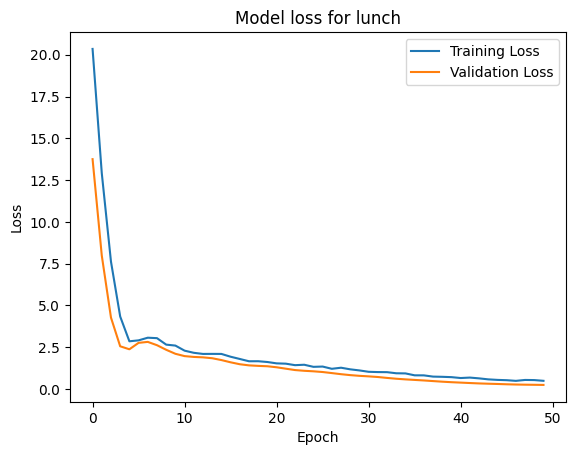

MAE : 0.3968606101399377
RMSE : 0.4860542737987827
Precision@k : 0.2833333333333333
Recall@k : 0.2833333333333333
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1000)              29000     
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_15 (Dense)            (None, 175)               175175    
                                                                 
Total params: 204,175
Trainable params: 204,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 150ms/step - loss: 19.2550 - val_loss: 12.6256
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 11.9120 - val_loss: 7.0648


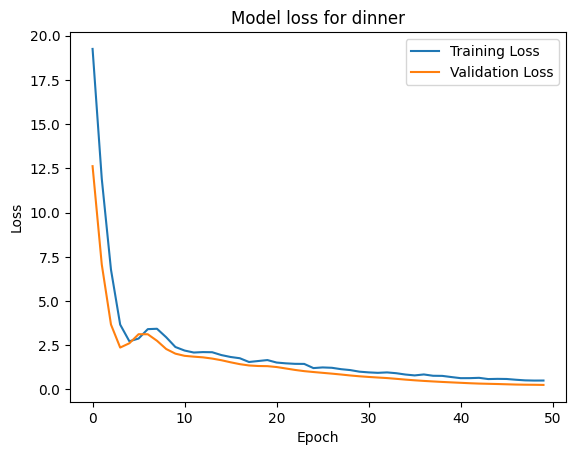

MAE : 0.4167820991379873
RMSE : 0.5064572529233518
Precision@k : 0.2666666666666667
Recall@k : 0.2666666666666667
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1000)              29000     
                                                                 
 dropout_8 (Dropout)         (None, 1000)              0         
                                                                 
 dense_17 (Dense)            (None, 175)               175175    
                                                                 
Total params: 204,175
Trainable params: 204,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 232ms/step - loss: 20.4544 - val_loss: 13.3056
Epoch 2/50
2/2 [==============================] - 0s 49ms/step - loss: 12.5201 - val_loss: 7.4670


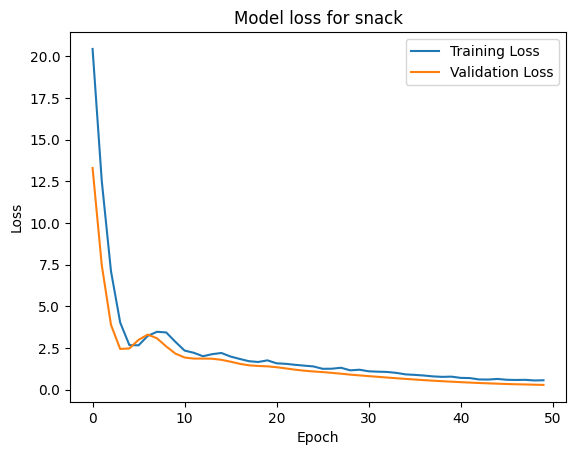

MAE : 0.42088177751813616
RMSE : 0.5296861290487226
Precision@k : 0.2833333333333334
Recall@k : 0.2833333333333334


In [47]:
#Train a model for each meal time
for meal_time in meal_times:
    X_meal = X[meal_time]
    y_meal = y[meal_time]
    run_recommendation_system(X_train, y_train, X_test, y_test)

In [49]:
# Function to create and compile the model
def create_model(X_train, y_train):
    model = Sequential([
        Dense(HIDDEN_UNITS, activation='relu', input_shape=(INPUT_LENGTH,)),
        Dropout(DROPOUT_RATE),
        Dense(y_train.shape[1], activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')
    return model

# Function to print model summary
def print_model_summary(model, meal_time):
    print(f"Model Summary for {meal_time}")
    model.summary()

# Function to train the model
def train_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))
    return history

#Function to evaluate model
def evaluate_model(model, X_test, y_test):
    predicted_ratings = model.predict(X_test)
    mae = mean_absolute_error(y_test, predicted_ratings)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_ratings))
    return mae, rmse, predicted_ratings 

def evaluate_and_plot_model(model, history, X_test, y_test, meal_time, k):
    mae, rmse, predicted_ratings = evaluate_model(model, X_test, y_test)

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss for ' + meal_time)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    print(f"Metrics for {meal_time}:")
    print("MAE :", mae)
    print("RMSE :", rmse)

    return mae, rmse

Model Summary for breakfast
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1000)              29000     
                                                                 
 dropout_10 (Dropout)        (None, 1000)              0         
                                                                 
 dense_21 (Dense)            (None, 175)               175175    
                                                                 
Total params: 204,175
Trainable params: 204,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 234ms/step - loss: 19.5524 - val_loss: 12.7383
Epoch 2/50
2/2 [==============================] - 0s 47ms/step - loss: 11.9842 - val_loss: 7.0718
Epoch 3/50
2/2 [==============================] - 0s 66ms/step - loss: 6.8999 - val_l

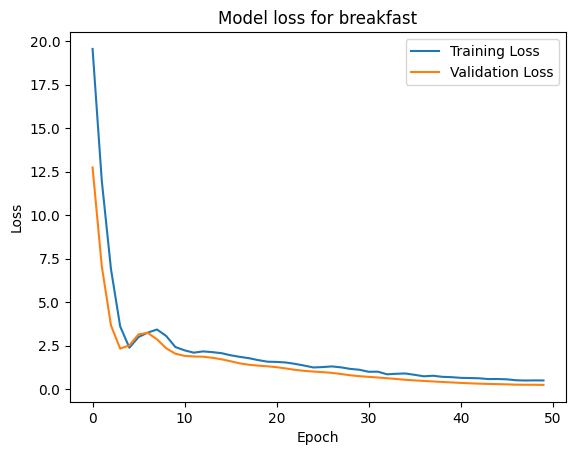

Metrics for breakfast:
MAE : 0.41104468037741526
RMSE : 0.4958643640123588
Model Summary for lunch
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1000)              29000     
                                                                 
 dropout_11 (Dropout)        (None, 1000)              0         
                                                                 
 dense_23 (Dense)            (None, 175)               175175    
                                                                 
Total params: 204,175
Trainable params: 204,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 153ms/step - loss: 19.9143 - val_loss: 13.4861
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 12.6076 - val_loss: 7.8625
Epoch 3/50
2/2

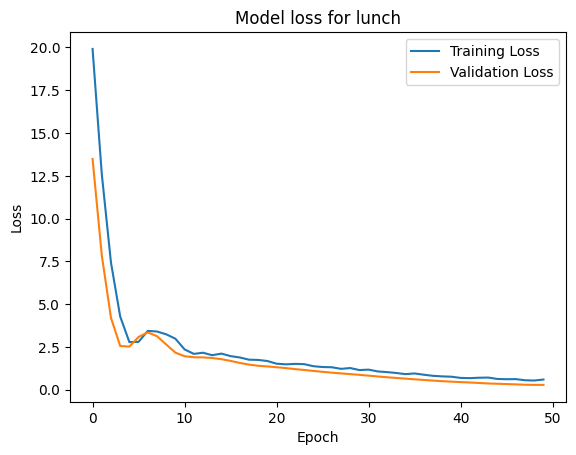

Metrics for lunch:
MAE : 0.4080124196279617
RMSE : 0.5320963762863742
Model Summary for dinner
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 1000)              29000     
                                                                 
 dropout_12 (Dropout)        (None, 1000)              0         
                                                                 
 dense_25 (Dense)            (None, 175)               175175    
                                                                 
Total params: 204,175
Trainable params: 204,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 174ms/step - loss: 20.4057 - val_loss: 13.6061
Epoch 2/50
2/2 [==============================] - 0s 37ms/step - loss: 12.8268 - val_loss: 7.8397
Epoch 3/50
2/2 [==

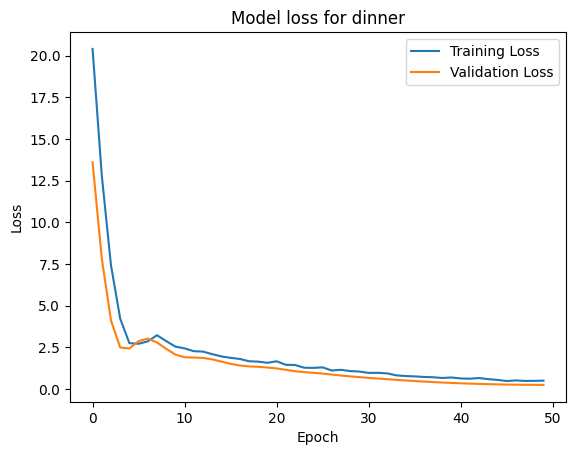

Metrics for dinner:
MAE : 0.41547668276287253
RMSE : 0.5025802644255377
Model Summary for snack
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 1000)              29000     
                                                                 
 dropout_13 (Dropout)        (None, 1000)              0         
                                                                 
 dense_27 (Dense)            (None, 175)               175175    
                                                                 
Total params: 204,175
Trainable params: 204,175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 1s 218ms/step - loss: 19.9196 - val_loss: 12.7796
Epoch 2/50
2/2 [==============================] - 0s 60ms/step - loss: 12.0497 - val_loss: 6.9792
Epoch 3/50
2/2 [=

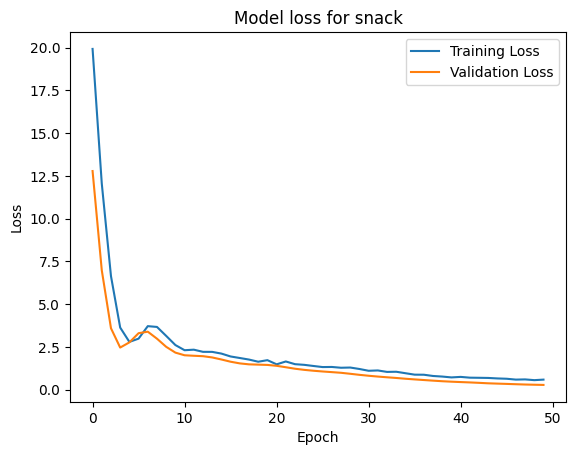

Metrics for snack:
MAE : 0.4126462547847202
RMSE : 0.5250634975401377


In [51]:
for meal_time in meal_times:
  model = create_model(X_train, y_train)
  print_model_summary(model, meal_time)
  history = train_model(model, X_train, y_train, X_test, y_test)
  mae, rmse = evaluate_and_plot_model(model, history, X_test, y_test, meal_time, TOP_N)